In [3]:
!pip install backtrader
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 11.4 MB/s eta 0:00:00


In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
import yfinance as yf
import datetime

In [40]:
import yfinance as yf

#downloading Amazon stock data from 2014-01-01 to 2019-10-01
df = yf.download('AMZN', start='2014-01-01', end='2019-10-01')

#to convert columns to strings
df.columns = [str(col) for col in df.columns]


/tmp/ipython-input-40-2568407563.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMZN', start='2014-01-01', end='2019-10-01')
[*********************100%***********************]  1 of 1 completed


In [45]:
print(df.shape)
print(df.head())


(1446, 5)
                Close     High        Low       Open    Volume
Date                                                          
2014-01-02  19.898500  19.9680  19.701000  19.940001  42756000
2014-01-03  19.822001  20.1355  19.811001  19.914499  44204000
2014-01-06  19.681499  19.8500  19.421000  19.792500  63412000
2014-01-07  19.901501  19.9235  19.714500  19.752001  38320000
2014-01-08  20.096001  20.1500  19.802000  19.923500  46330000


In [46]:
print(df.index)
print(type(df.index))


DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-30'],
              dtype='datetime64[ns]', name='Date', length=1446, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [44]:
df.columns = [col.split(',')[0].replace("('", '').replace("'", '').strip() for col in df.columns]


In [47]:
#print columns
print(df.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [48]:
import backtrader as bt

#creating Backtrader data feed from the DataFrame
data = bt.feeds.PandasData(dataname=df)

#Adding data to Cerebro engine
cerebro = bt.Cerebro()
cerebro.adddata(data)


In [49]:
type(data)

backtrader.feeds.pandafeed.PandasData

In [50]:
cerebro.addstrategy(Sar_ichi)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=.0001)
cerebro.addsizer(bt.sizers.PercentSizer, percents=85)

In [5]:
class Sar_ichi(bt.Strategy):

  params = (('period', 2),('af',0.02), ('afmax',0.2), ('pfast',12), ('pslow',26))

#abbreviations:
#period: Period for Parabolic SAR calculation.
#af (Acceleration Factor): Controls sensitivity of Parabolic SAR.
#afmax (Maximum Acceleration Factor): it Caps the sensitivity of Parabolic SAR.
#pfast: Period for the fast simple moving average.
#pslow: Period for the slow simple moving average.


  def __init__(self):
    self.order = None
    self.close = self.data.close
    self.p_sar = bt.indicators.ParabolicSAR(period=self.params.period, af=self.params.af, afmax=self.params.afmax)
    sma1 = bt.indicators.SMA(period=self.params.pfast)  #fast moving average
    sma2 = bt.indicators.SMA(period=self.params.pslow)  #slow moving average
    self.crossover = bt.ind.CrossOver(sma1, sma2)  #crossover signal
    self.macd_signal = False
    self.para_signal = False
    self.Long = False

  def log(self, text):
    dt = self.datas[0].datetime.date(0)
    print(dt.isoformat(), ', '+text)



  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
        self.Long = True
      if order.issell():
        self.log('SELL EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
        self.Long = False


      #  self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('ORDER CANCELLED/ MARGIN/ REJECTED')

    self.order = None
  def notify_trade(self, trade):
    if not trade.isclosed:
      return

    self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
              (trade.pnl, trade.pnlcomm))

  def next(self):  #core trading logic

    if ( self.p_sar.psar[0] < self.close[0] ):
      self.para_signal = True

    if self.para_signal:
      if self.crossover > 0:
        self.macd_signal = True

    if self.macd_signal:
      if (self.close[0] < self.p_sar.psar[0]):
        if not self.Long:
          self.buy()

    if (self.close[0] < self.p_sar.psar[0]):
      self.para_signal = False

    if not self.para_signal:
      if self.crossover < 0:
        self.macd_signal = False

    if not self.macd_signal:
      if (self.close[0] > self.p_sar.psar[0]):
        if  self.Long:
          self.sell()


  def stop(self):
    if self.Long:
      self.sell()









In [52]:
type(cerebro)

backtrader.cerebro.Cerebro

In [53]:
#adding all the metrics we need to check performance

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sr')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='ar')
cerebro.addanalyzer(bt.analyzers.Returns, _name='r')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pf')

In [55]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strat = cerebro.run()
strats = strat[0]
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
2014-03-21 , BUY EXECUTED :Price- 18.549999, Cost- 85467.651166, Commission- 8.546765
2014-04-17 , SELL EXECUTED :Price- 15.988000, Cost- 85467.651166, Commission- 7.366344
2014-04-17 , OPERATION PROFIT, GROSS -11804.21, NET -11820.12
2014-06-16 , BUY EXECUTED :Price- 16.243000, Cost- 74628.984529, Commission- 7.462898
2014-08-18 , SELL EXECUTED :Price- 16.774000, Cost- 74628.984529, Commission- 7.706868
2014-08-18 , OPERATION PROFIT, GROSS 2439.70, NET 2424.53
2014-09-10 , BUY EXECUTED :Price- 16.715000, Cost- 78076.410208, Commission- 7.807641
2014-10-06 , SELL EXECUTED :Price- 16.174999, Cost- 78076.410208, Commission- 7.555405
2014-10-06 , OPERATION PROFIT, GROSS -2522.37, NET -2537.73
2014-12-04 , BUY EXECUTED :Price- 15.776500, Cost- 74627.256883, Commission- 7.462726
2014-12-24 , SELL EXECUTED :Price- 15.319000, Cost- 74627.256883, Commission- 7.246316
2014-12-24 , OPERATION PROFIT, GROSS -2164.10, NET -2178.81
2015-03-09 , BUY EXECUTED :Price

In [56]:
print('Sharpe Ratio:', strats.analyzers.sr.get_analysis())
print('Drawdown:', strats.analyzers.dd.get_analysis())
print('Annual Return:', strats.analyzers.ar.get_analysis())
print('Returns:', strats.analyzers.r.get_analysis())
print('SQN:', strats.analyzers.sqn.get_analysis())
print('Trade Analyzer:',strats.analyzers.ta.get_analysis())


Sharpe Ratio: OrderedDict([('sharperatio', 0.673962263369734)])
Drawdown: AutoOrderedDict([('len', 269), ('drawdown', 20.02732316076757), ('moneydown', 63314.86532150721), ('max', AutoOrderedDict([('len', 329), ('drawdown', 29.64781858929886), ('moneydown', 93729.33297122628)]))])
Annual Return: OrderedDict([(2014, -0.14112132330422344), (2015, 0.6891590342392144), (2016, 0.13376582865911368), (2017, 0.4267712360816429), (2018, 0.03845071916419385), (2019, 0.03742916634716642)])
Returns: OrderedDict([('rtot', 0.9275374923728074), ('ravg', 0.000641450547975662), ('rnorm', 0.1754435175145328), ('rnorm100', 17.54435175145328)])
SQN: AutoOrderedDict([('sqn', 1.4939463973946183), ('trades', 15)])
Trade Analyzer: AutoOrderedDict([('total', AutoOrderedDict([('total', 16), ('open', 1), ('closed', 15)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 4)])), ('lost', AutoOrderedDict([('current', 1), ('longest', 3)]))])), ('pnl', AutoOrderedDict([('gross', AutoO

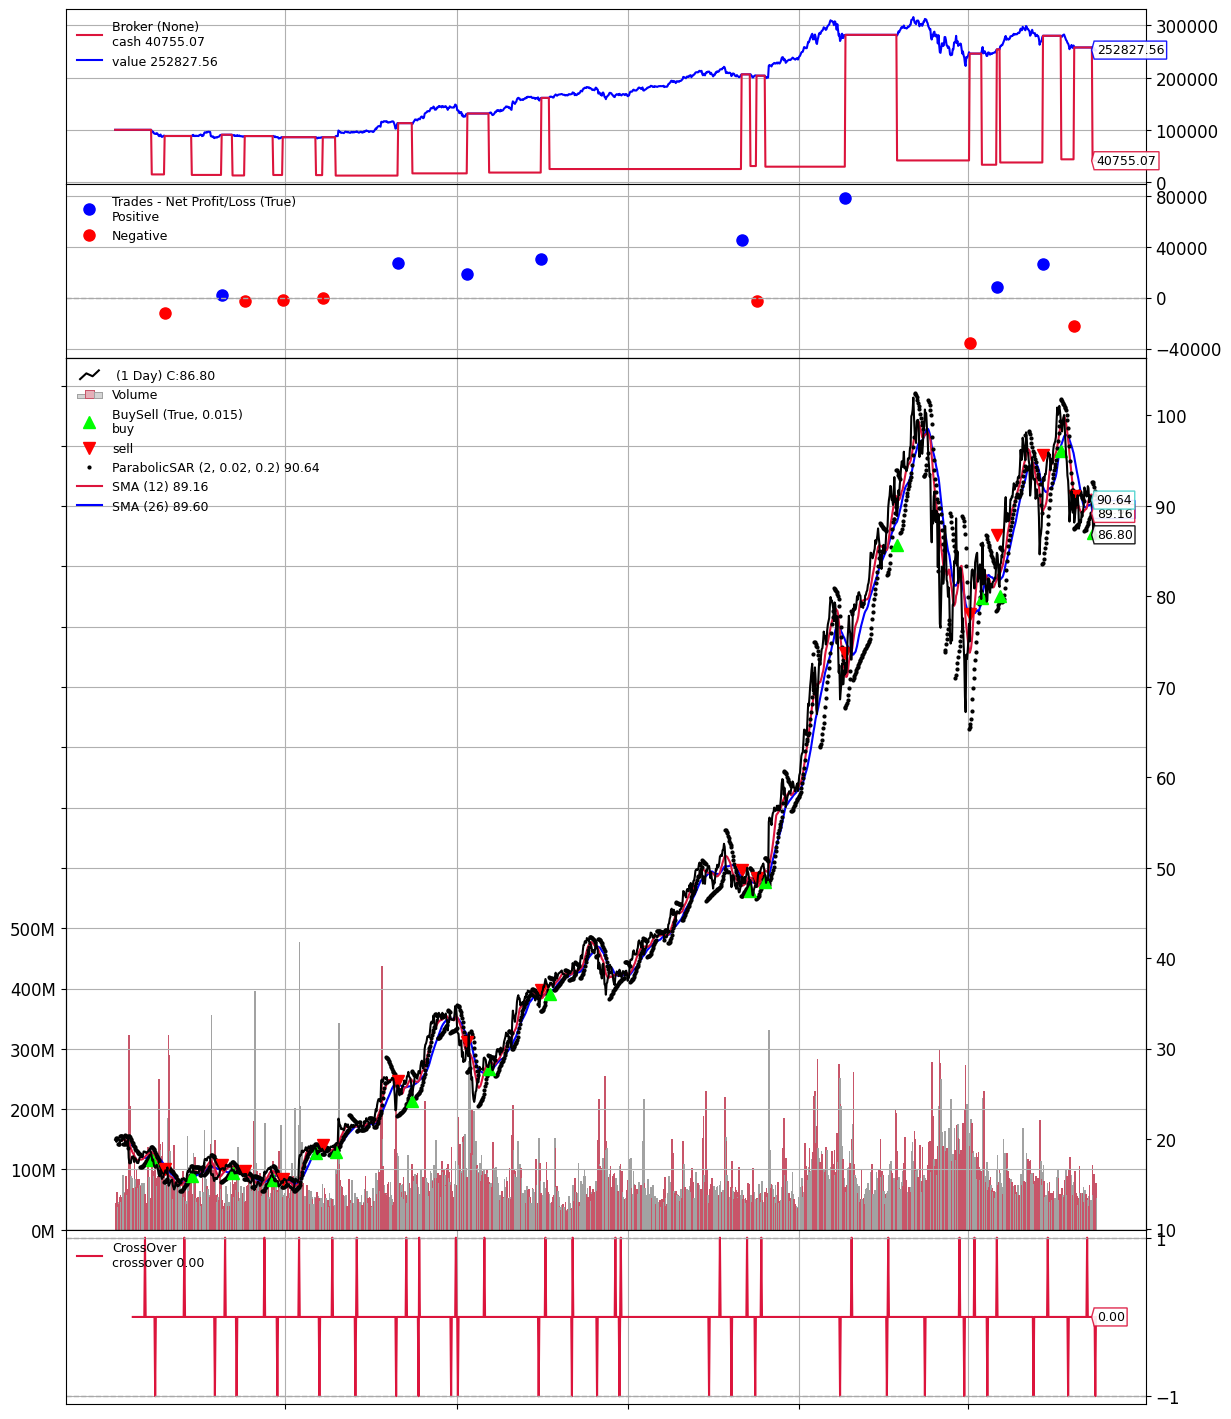

[[<Figure size 1200x1500 with 5 Axes>]]

In [57]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 15]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot = False)